In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_data_template
from src.features.games_detailed import GameDetailedFeatures

In [23]:
from src.features.games_detailed import GameDetailedFeatures
data = load_data_template(season=False)
game_detail_feat = GameDetailedFeatures(default_lags=3)
data = game_detail_feat.per_team_wrapper(data, game_detail_feat.detail_features_by_game, per_day=True)
data.dropna(inplace=True)
print(data.shape)
data.sample()

(981, 85)


,Season,team_a,team_b,in_target,game_set,a_win,DayNum,FGM_game_team_a_lag-1,FGM_game_team_a_lag-2,FGM_game_team_a_lag-3,...,TO_game_team_b_lag-3,Stl_game_team_b_lag-1,Stl_game_team_b_lag-2,Stl_game_team_b_lag-3,Blk_game_team_b_lag-1,Blk_game_team_b_lag-2,Blk_game_team_b_lag-3,PF_game_team_b_lag-1,PF_game_team_b_lag-2,PF_game_team_b_lag-3
10953,2013,1242,1276,False,0,False,144,21.0,25.0,18.0,...,4.0,7.0,6.0,6.0,0.0,3.0,9.0,7.0,8.0,10.0


In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss


cat_cols = ['team_a', 'team_b', 'game_set']
X = data.drop(['Season', 'a_win', 'in_target', 'DayNum'], axis=1)
X_enc = OneHotEncoder(categorical_features=[c in cat_cols for c in X.columns]).fit_transform(X).todense()
y = data[['a_win', 'game_set']].astype({'a_win': int})

kf = KFold(n_splits=3, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X_enc):
    X_tr, y_tr = X_enc[tr_i], y.iloc[tr_i].a_win
    X_t, y_t = X_enc[t_i], y.iloc[t_i].a_win
    xgb = XGBClassifier(nthreads=4)
    xgb.fit(X_tr, y_tr)
    preds = xgb.predict_proba(X_t)
    ncaa_true = y.iloc[t_i][y.iloc[t_i].game_set == 0]
    ncaa_pred = preds[y.iloc[t_i].reset_index().game_set == 0]
    metric = log_loss(ncaa_true.a_win.astype(int), ncaa_pred)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

0.19487637221074125
0.20227726152742037
0.18021061243873876
Metric Mean: 0.19 (0.01)


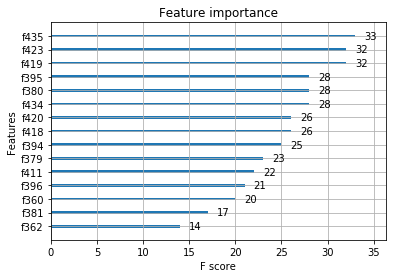

In [25]:
from xgboost import plot_importance

plt.figure(figsize=(20,4))
plot_importance(xgb, max_num_features=15)
plt.show()